# EqualFrequencyDiscretiser + WoEEncoder

This is very useful for linear models, because by using discretisation + a monotonic encoding, we create monotonic variables with the target, from those that before were not originally. And this tends to help improve the performance of the linear model. 

## EqualFrequencyDiscretiser

The EqualFrequencyDiscretiser() divides continuous numerical variables
into contiguous equal frequency intervals, that is, intervals that contain
approximately the same proportion of observations.

The interval limits are determined by the quantiles. The number of intervals,
i.e., the number of quantiles in which the variable should be divided is
determined by the user.

<b>Note</b>: Check out the EqualFrequencyDiscretiser notebook to larn more about this transformer.

## WoEEncoder

This encoder replaces the labels by the weight of evidence.

**It only works for binary classification.**

<b>Note:</b> Check out the WoEEncoder notebook to learn more about this transformer.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.encoding import WoEEncoder

plt.rcParams["figure.figsize"] = [15,5]

In [2]:
# Load titanic dataset from OpenML

def load_titanic():
    data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')
    data = data.replace('?', np.nan)
    data['cabin'] = data['cabin'].astype(str).str[0]
    data['pclass'] = data['pclass'].astype('O')
    data['age'] = data['age'].astype('float').fillna(data.age.median())
    data['fare'] = data['fare'].astype('float').fillna(data.fare.median())
    data['embarked'].fillna('C', inplace=True)
    data.drop(labels=['boat', 'body', 'home.dest', 'name', 'ticket'], axis=1, inplace=True)
    return data

In [3]:
data = load_titanic()
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked
0,1,1,female,29.0000,0,0,211.3375,B,S
1,1,1,male,0.9167,1,2,151.5500,C,S
2,1,0,female,2.0000,1,2,151.5500,C,S
3,1,0,male,30.0000,1,2,151.5500,C,S
4,1,0,female,25.0000,1,2,151.5500,C,S


In [4]:
# let's separate into training and testing set
X = data.drop(['survived'], axis=1)
y = data.survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("X_train :" ,X_train.shape)
print("X_test :" ,X_test.shape)

X_train : (916, 8)
X_test : (393, 8)


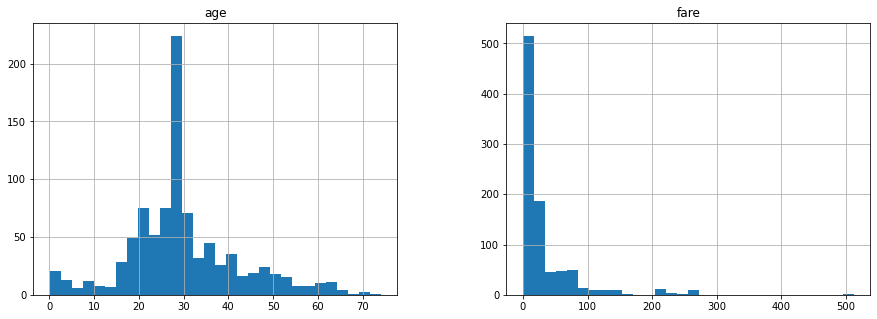

In [5]:
# we will use two continuous variables for the transformations
X_train[["age", 'fare']].hist(bins=30)
plt.show()

In [8]:
# set up the discretiser

efd = EqualFrequencyDiscretiser(
    q=4,
    variables=['age', 'fare'],
    # important: return values as categorical
    return_object=True)

# set up the encoder
woe = WoEEncoder(variables=['age', 'fare'])

# pipeline
transformer = Pipeline(steps=[('EqualFrequencyDiscretiser', efd),
                              ('WoEEncoder', woe),
                              ])

transformer.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('EqualFrequencyDiscretiser',
                 EqualFrequencyDiscretiser(q=4, return_boundaries=False,
                                           return_object=True,
                                           variables=['age', 'fare'])),
                ('WoEEncoder', WoEEncoder(variables=['age', 'fare']))],
         verbose=False)

In [9]:
transformer.named_steps['EqualFrequencyDiscretiser'].binner_dict_

{'age': [-inf, 23.0, 28.0, 35.0, inf],
 'fare': [-inf, 7.8958, 14.4542, 31.275, inf]}

In [10]:
transformer.named_steps['WoEEncoder'].encoder_dict_

{'age': {0: 0.07533270507296917,
  1: -0.260402163917158,
  2: 0.3237107275657203,
  3: 0.05769015189511875},
 'fare': {0: -0.5990108946387251,
  1: -0.41504696424627724,
  2: 0.142571903020815,
  3: 0.7852653023249282}}

In [11]:
train_t = transformer.transform(X_train)
test_t = transformer.transform(X_test)

test_t.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked
1139,3,male,0.057690,0,0,-0.599011,n,S
533,2,female,0.075333,0,1,0.142572,n,S
459,2,male,0.057690,1,0,0.142572,n,S
1150,3,male,-0.260402,0,0,0.142572,n,S
393,2,male,-0.260402,0,0,0.785265,n,S


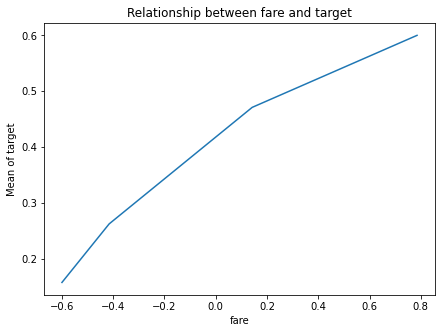

In [15]:
# let's explore the monotonic relationship
plt.figure(figsize=(7,5))
pd.concat([test_t,y_test], axis=1).groupby("fare")["survived"].mean().plot()
plt.title("Relationship between fare and target")
plt.xlabel("fare")
plt.ylabel("Mean of target")
plt.show()

Note how now the intervals are monotonically sorted respect to the target.